<a href="https://colab.research.google.com/github/devashishk99/Sarcasm-Detection/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


In [1]:
import numpy as np 
import pandas as pd 

import os
import re
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.express as px
from plotly.offline import init_notebook_mode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Loading & Preprocessing


In [2]:
data1 = pd.read_json('/content/drive/My Drive/sarcasm detection/data/Sarcasm_Headlines_Dataset_v2.json', lines=True)
data2 = pd.read_json('/content/drive/My Drive/sarcasm detection/data/Sarcasm_Headlines_Dataset.json', lines=True)

Checking the dataset i.e column names and other metadata

In [5]:
data1.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Merging the two data blocks

In [3]:
#data1 = data1[['headline','is_sarcastic']]
#data2 = data2[['headline','is_sarcastic']]

data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)

Adding a new column which extracts the source of the news headlines from the article link

In [4]:
# Let's use regex on the "article_link" column to get the source data.
data["source"] = data["article_link"].apply(lambda string: re.findall('[a-zA-Z]+', string)[2] )
data = data.drop(['article_link'],axis = 1)

In [5]:
data.head()

,is_sarcastic,headline,source
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


In [6]:
data.shape

(55328, 3)

The dataset consists of 55328 rows 

Checking for null data

In [7]:
data.isnull().sum()

is_sarcastic    0
headline        0
source          0
dtype: int64

There exist some contractions in the dataset that we will expand

In [5]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the title, text
data['headline'] = data['headline'].apply(lambda x:expand_contractions(x))

In [9]:
data.head()

,is_sarcastic,headline,source
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word istre...,theonion


In [10]:
data['source'].value_counts()

huffingtonpost    29970
theonion          25358
Name: source, dtype: int64

We see there almost the same no. of headlines from the two sources

Checking if dataset is balanced or not

In [11]:
data["is_sarcastic"].value_counts()

0    29970
1    25358
Name: is_sarcastic, dtype: int64

Text(0, 0.5, 'Label Count')

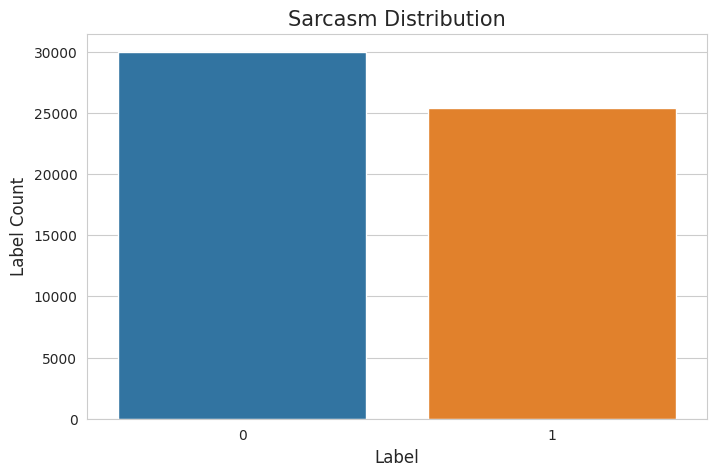

In [12]:
plt.figure(figsize = (8, 5))
bal_plot = data.groupby(['is_sarcastic']).size()
sns.barplot(x=bal_plot.index, y=bal_plot.values)
plt.title('Sarcasm Distribution', fontsize=15)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Label Count", fontsize=12)

As we see from the plot, the dataset is almost balanced 

Text(0, 0.5, 'Count')

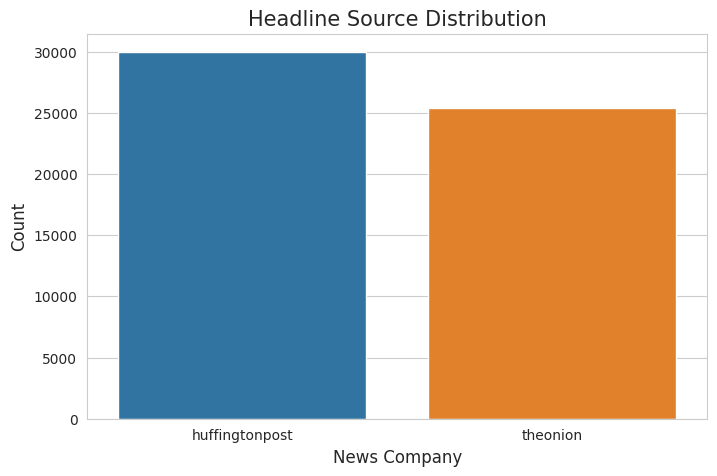

In [58]:
plt.figure(figsize = (8, 5))
bal_plot = data.groupby(['source']).size()
sns.barplot(x=bal_plot.index, y=bal_plot.values)
plt.title('Headline Source Distribution', fontsize=15)
plt.xlabel("News Company", fontsize=12)
plt.ylabel("Count", fontsize=12)

In [6]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x): 

    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower().split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

In [61]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|██████████| 55328/55328 [06:51<00:00, 134.47it/s]


In [7]:
data['cleaned_headline'] = data['headline'].apply(text_cleaning)

Adding new columns to store the length of characters and words in the headlines 

In [8]:
data['sentence_length'] = data['cleaned_headline'].apply(lambda x: len(x.split()))
data['char_count'] = data['cleaned_headline'].apply(lambda x: len(x))

In [16]:
data.head()

,is_sarcastic,headline,source,cleaned_headline,sentence_length,char_count
0,1,thirtysomething scientists unveil doomsday clo...,theonion,thirtysomething scientists unveil doomsday clo...,7,58
1,0,dem rep. totally nails why congress is falling...,huffingtonpost,dem rep totally nail congress fall short gende...,10,63
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost,eat veggies 9 deliciously different recipes,6,43
3,1,inclement weather prevents liar from getting t...,theonion,inclement weather prevent liar get work,6,39
4,1,mother comes pretty close to using word istre...,theonion,mother come pretty close use word istreaming c...,8,54


Checking for outlying headlines based on their length

Text(0, 0.5, 'Label Count')

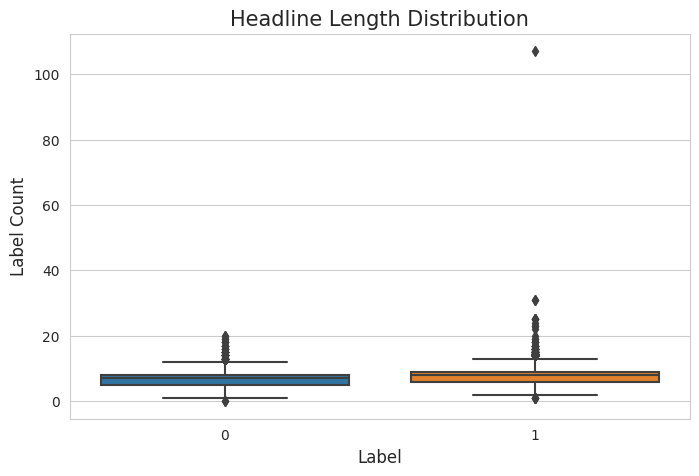

In [17]:
plt.figure(figsize = (8, 5))
sns.boxplot(data=data, x="is_sarcastic", y="sentence_length", orient="v")
plt.title('Headline Length Distribution', fontsize=15)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Label Count", fontsize=12)

<Axes: title={'center': 'Headline Length Distribution'}, xlabel='Length', ylabel='Sentence Count'>

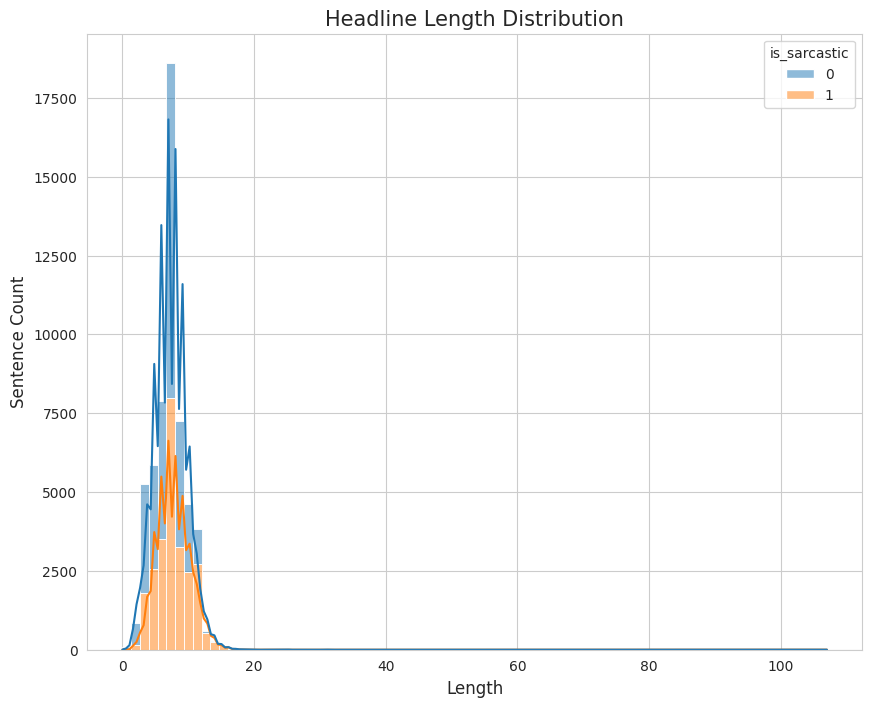

In [18]:
plt.figure(figsize = (10, 8))
plt.title('Headline Length Distribution', fontsize=15)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Sentence Count", fontsize=12)
sns.histplot(data=data, hue="is_sarcastic", x="sentence_length", bins=80, multiple="stack", kde=True)

The farthest outlier has length of 107 which is quite unusual for a headline 

In [19]:
data[data['sentence_length']==107]['headline']

7302    hot wheels ranked number one toy for rolling d...
Name: headline, dtype: object

In [9]:
data.drop(data[data['sentence_length'] == 107].index, inplace = True)
data.reset_index(inplace=True, drop=True)

Text(0, 0.5, 'Label Count')

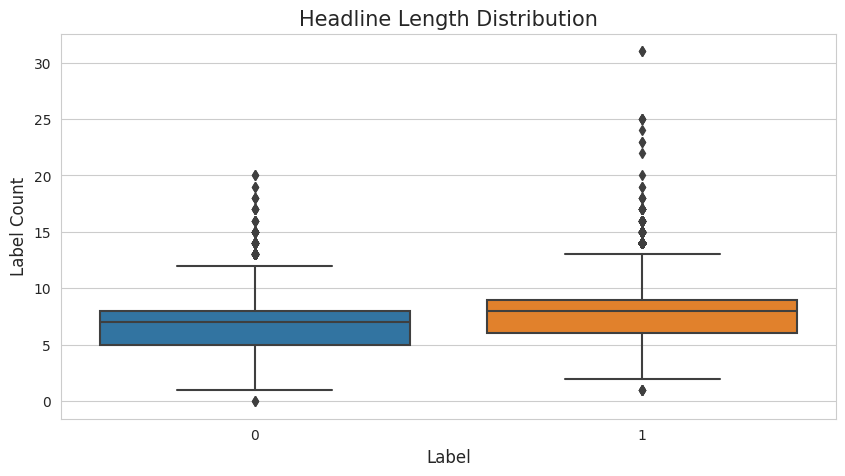

In [21]:
plt.figure(figsize = (10, 5))
sns.boxplot(data=data, x="is_sarcastic", y="sentence_length", orient="v")
plt.title('Headline Length Distribution', fontsize=15)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Label Count", fontsize=12)

<Axes: title={'center': 'Headline Length Distribution'}, xlabel='Length', ylabel='Sentence Count'>

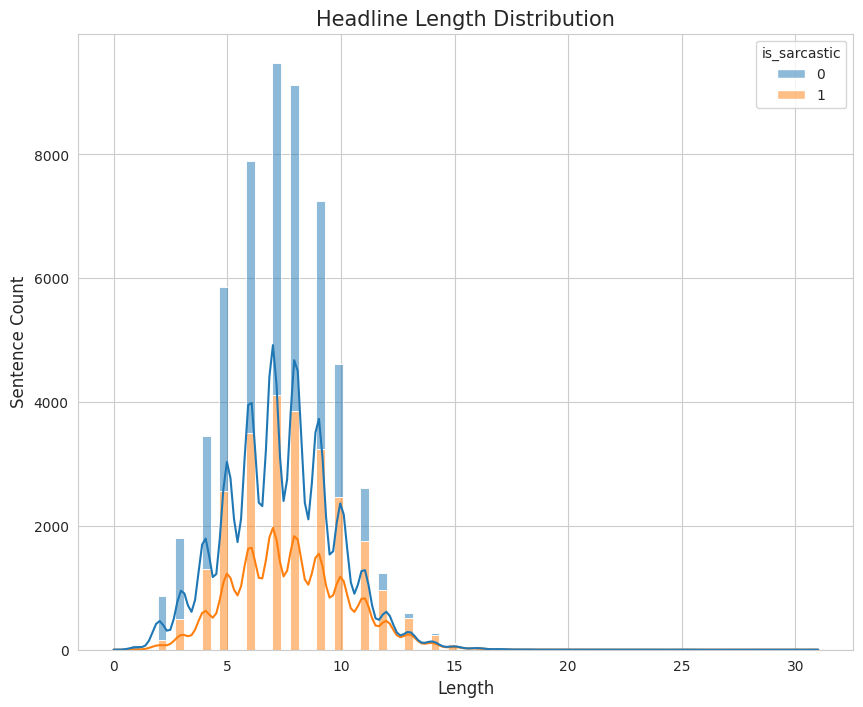

In [23]:
plt.figure(figsize = (10, 8))
plt.title('Headline Length Distribution', fontsize=15)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Sentence Count", fontsize=12)
sns.histplot(data=data, hue="is_sarcastic", x="sentence_length", bins=80, multiple="stack", kde=True)

Top 15 Bigrams

In [24]:
def get_top_nwords(x, n, i):
    vec = CountVectorizer(ngram_range=(i,i)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

In [27]:
type(data.cleaned_headline)

pandas.core.series.Series

In [25]:
# Bigram
words = get_top_nwords(data.cleaned_headline, 15, 2) 
df_bi = pd.DataFrame(words, columns=['Bigram', 'Frequency'])
df_bi.head()

,Bigram,Frequency
0,donald trump,924
1,year old,529
2,area man,520
3,white house,395
4,hillary clinton,357


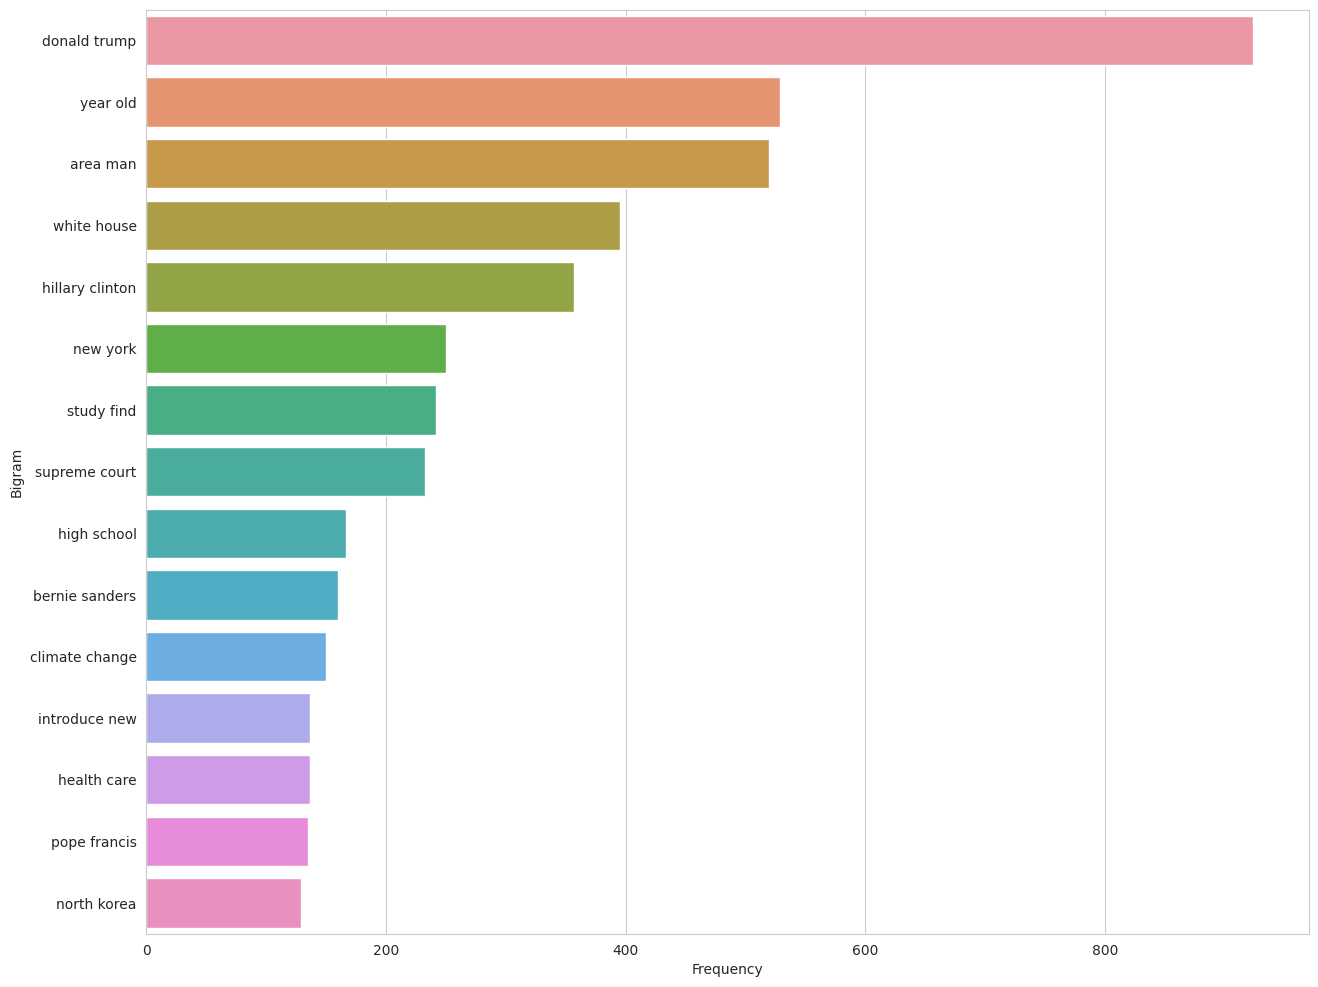

In [26]:
plt.figure(figsize = (15, 12))
ax = sns.barplot(y='Bigram', x='Frequency', orient = "h", data=df_bi)

The headlines are now distributed within the maximum length of 25-30 and mostly centered around 5-10

# Word Cloud

In [28]:
sarcastic = data[data['is_sarcastic']==1]['cleaned_headline'].tolist()
authentic = data[data['is_sarcastic']==0]['cleaned_headline'].tolist()

stopwords = set(STOPWORDS)
stopwords.update(["one", "first", "will", "want", "give"])

### Top 100 Sarcastic Headlines

There are 1311080 words in the combination of sarcastic headlines.


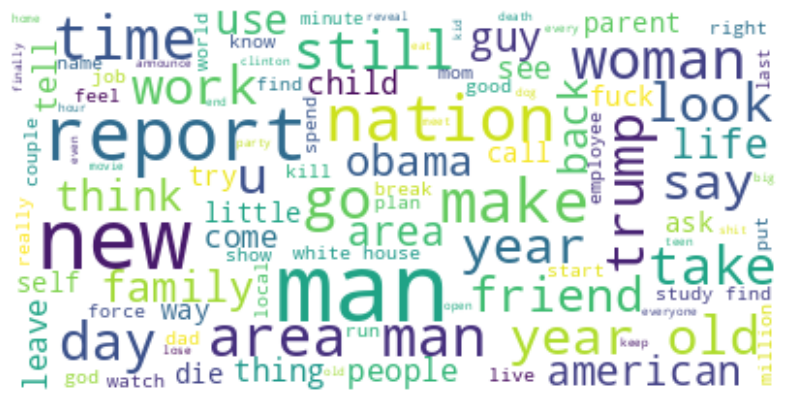

In [29]:
texts = " ".join(sarcastic)
print ("There are {} words in the combination of sarcastic headlines.".format(len(texts)))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100,
                      stopwords=stopwords,
                      background_color="white").generate(texts)

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
#wordcloud.to_file("sarcastic_wc.png")

### Top 100 Authentic Headlines

There are 1375857 words in the combination of sarcastic headlines.


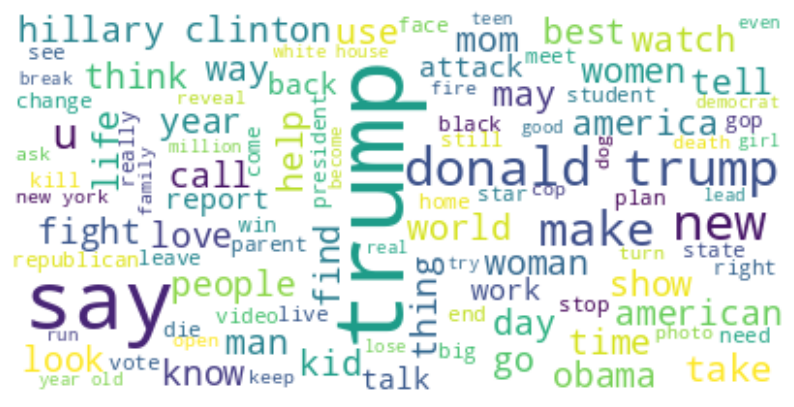

In [65]:
texts = " ".join(authentic)
print ("There are {} words in the combination of sarcastic headlines.".format(len(texts)))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100,
                      stopwords=stopwords,
                      background_color="white").generate(texts)

# Display the generated image:
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
#wordcloud.to_file("authentic.png")

# Model Training

In [10]:
def tokenize(text):
    # Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [11]:
sentences = data['cleaned_headline']
label = data['is_sarcastic']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

## Random Forest

In [16]:
# Instantiate transformers and classifier
vect = CountVectorizer(tokenizer=tokenize)
tfidf = TfidfTransformer()
clf = RandomForestClassifier()


# Fit and/or transform each to the training data
# Hint: you can use the fit_transform method
X_train_counts = vect.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train_counts)

# Fit or train the classifier
clf.fit(X_train_tfidf, y_train)
     

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



RandomForestClassifier()

In [18]:
# Transform test data
X_test_counts = vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_counts)

# Predict test labels
y_pred = clf.predict(X_test_tfidf)

In [88]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      5994
           1       0.96      0.93      0.94      5072

    accuracy                           0.95     11066
   macro avg       0.95      0.95      0.95     11066
weighted avg       0.95      0.95      0.95     11066



In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7687748539812157

## Gaussian Naive Bayes Theorem

In [19]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train_tfidf.toarray(), y_train)


# Predict test labels
y_pred = model.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82      5994
           1       0.89      0.60      0.72      5072

    accuracy                           0.78     11066
   macro avg       0.81      0.77      0.77     11066
weighted avg       0.81      0.78      0.77     11066



In [22]:
roc_auc_score(y_test, y_pred)

0.7687748539812157

## Support Vector Machine

In [23]:
from sklearn import svm

model = svm.SVC(kernel='linear', gamma=1) 

# Train the model using the training sets
model.fit(X_train_counts, y_train)

# Predict test labels
y_pred = model.predict(X_test_counts.toarray())

print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5994
           1       0.89      0.88      0.89      5072

    accuracy                           0.90     11066
   macro avg       0.90      0.89      0.90     11066
weighted avg       0.90      0.90      0.90     11066



In [24]:
roc_auc_score(y_test, y_pred)

0.8945175788301446

## K-Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)

# Train the model using the training sets
knn.fit(X_train_tfidf.toarray(), y_train)

# Predict test labels
y_pred = knn.predict(X_test_tfidf.toarray())

print(classification_report(y_test.values, y_pred))

In [26]:
roc_auc_score(y_test, y_pred)

0.876099515656561

## BERT

In [29]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.2 MB/s eta 0:00:00


In [30]:
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [57]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
bert_model = BertModel.from_pretrained('prajjwal1/bert-tiny')

In [32]:
class SarcasmDataset(Dataset):

    def __init__(self, X, Y):

        self.labels = np.array(Y)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512,
                                # truncation=True,
                                return_tensors="pt") for text in X]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [33]:
class BertClassifier(nn.Module):

    def __init__(self, bert_model, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [37]:
import matplotlib.pyplot as plt

In [50]:
def train(model, X,Y, learning_rate, epochs, batch_size):
    
    train = SarcasmDataset(X,Y)
    # , Dataset(val_data)

    train_dataloader = DataLoader(train, batch_size, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
           
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(X): .3f} | Train Accuracy: {total_acc_train / len(X): .3f}')
          
    
                 

In [35]:
def evaluate(model, X,Y, batch_size):

    test = SarcasmDataset(X, Y)

    test_dataloader = DataLoader(test, batch_size,shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    y_pred = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            y_pred.append(output.argmax(dim=1))

    return y_pred

In [52]:
#Hyperparameters for tiny-bert
EPOCHS = 5
batch_size = 32
model = BertClassifier(bert_model)
LR = 1e-4
              
train(model, X_train, y_train, LR, EPOCHS, batch_size)

100%|██████████| 1384/1384 [00:51<00:00, 27.08it/s]


Epochs: 1 | Train Loss:  0.001 | Train Accuracy:  0.989


100%|██████████| 1384/1384 [00:51<00:00, 26.87it/s]


Epochs: 2 | Train Loss:  0.000 | Train Accuracy:  0.999


100%|██████████| 1384/1384 [00:49<00:00, 27.68it/s]


Epochs: 3 | Train Loss:  0.000 | Train Accuracy:  0.999


100%|██████████| 1384/1384 [00:49<00:00, 27.69it/s]


Epochs: 4 | Train Loss:  0.000 | Train Accuracy:  1.000


100%|██████████| 1384/1384 [00:50<00:00, 27.66it/s]


Epochs: 5 | Train Loss:  0.000 | Train Accuracy:  1.000


In [ ]:
#Hyperparameters for bert-base-uncased
EPOCHS = 3
batch_size = 8
model = BertClassifier(bert_model)
LR = 1e-3
              
train(model, X_train, y_train, LR, EPOCHS, batch_size)

In [53]:
y_pred = evaluate(model, X_test,y_test, batch_size)

In [54]:
y_pred_ = torch.cat(y_pred, dim=0)

In [55]:
y_pred_=y_pred_.cpu().detach().numpy()

In [56]:
print(classification_report(y_test.values, y_pred_))
print(roc_auc_score(y_test, y_pred_))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5994
           1       0.95      0.95      0.95      5072

    accuracy                           0.95     11066
   macro avg       0.95      0.95      0.95     11066
weighted avg       0.95      0.95      0.95     11066

0.9539092523122492
